In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from torch import Tensor
from tensordict import TensorDict
from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.rl.common.base import RL4COLitModule
from rl4co.models.rl.common.utils import RewardScaler
from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer
from python_tsp.heuristics import solve_tsp_local_search

In [39]:
class CustomGATEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=3, num_heads = 1, p_dropout = 0.5):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.p_dropout = p_dropout
        self.loc_embed = nn.Linear(input_dim, hidden_dim, bias=True)  # Initial embedding of the loc coordinates
        self.layers = nn.ModuleList([GATConv(hidden_dim, hidden_dim, num_heads, concat=True, edge_dim=2) for _ in range(num_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim*num_heads) for _ in range(num_layers - 1)])

    def forward(self, td):
        locs = td["locs"] 
        edge_means = td["edge_means"]
        edge_vars = td["edge_vars"]
        loc_embedding = self.loc_embed(locs)
        batch_size, num_nodes, _ = loc_embedding.shape

        x = loc_embedding.reshape(-1, self.hidden_dim) # Convert from [batch_size, num_nodes, hidden_dim] to [batch_size*num_nodes, hidden_dim]
        edge_index = self.build_fully_connected_edge_index(batch_size, num_nodes, self_loops = True)
        edge_attrs = torch.stack([edge_means.flatten(), edge_vars.flatten()], dim=1)
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = layer(x, edge_index, edge_attr = edge_attrs)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.p_dropout)
        
        x = self.layers[-1](x, edge_index, edge_attr = edge_attrs)
        x = x.view(batch_size, num_nodes, self.hidden_dim)

        return x, None

    def build_fully_connected_edge_index(self, batch_size, num_nodes, self_loops = False):
        row = torch.arange(num_nodes).repeat_interleave(num_nodes)
        col = torch.arange(num_nodes).repeat(num_nodes)
        if not self_loops:
            mask = row != col 
            row, col = row[mask], col[mask]
        edge_index = torch.stack([row, col], dim=0).to(device)

        batch_edge_index = edge_index.repeat(1, batch_size)

        return batch_edge_index


In [40]:
class Simple_REINFORCE(RL4COLitModule):
    def __init__(
        self,
        env: RL4COEnvBase,
        policy: nn.Module,
        reward_scale: str = None,
        **kwargs,
    ):
        super().__init__(env, policy, **kwargs)
        self.reward_scaler = RewardScaler(reward_scale)

    def shared_step(self, batch, batch_idx, phase, dataloader_idx= None):
        td = self.env.reset(batch)
        out = self.policy(td, self.env, phase=phase, select_best=phase != "train")

        # Compute loss
        if phase == "train":
            out = self.calculate_loss(td, batch, out)

        metrics = self.log_metrics(out, phase, dataloader_idx=dataloader_idx)
        return {"loss": out.get("loss", None), **metrics}

    def calculate_loss(self, td, batch, policy_out, reward = None, log_likelihood = None):
        reward = policy_out["reward"]
        log_likelihood = policy_out["log_likelihood"]

        # Compute loss
        reward = self.reward_scaler(reward)
        loss = -(reward * log_likelihood).mean()
        policy_out.update(
            {
                "loss": loss,
            }
        )
        return policy_out

In [41]:
def gather_by_index(src, idx, dim=1, squeeze=True):
    """Gather elements from src by index idx along specified dim

    Example:
    >>> src: shape [64, 20, 2]
    >>> idx: shape [64, 3)] # 3 is the number of idxs on dim 1
    >>> Returns: [64, 3, 2]  # get the 3 elements from src at idx
    """
    expanded_shape = list(src.shape)
    expanded_shape[dim] = -1
    idx = idx.view(idx.shape + (1,) * (src.dim() - idx.dim())).expand(expanded_shape)
    squeeze = idx.size(dim) == 1 and squeeze
    return src.gather(dim, idx).squeeze(dim) if squeeze else src.gather(dim, idx)

In [42]:
class TSPEnv_StochasticTravel(TSPEnv):
    def __init__(self, travel_sds=0.1, **kwargs):
        super().__init__(**kwargs)
        self.travel_sds = travel_sds

    def _reset(self, td = None, batch_size=None):
        td = super()._reset(td, batch_size)
        locs = td["locs"]  # Node locations [batch_size, num_nodes, 2]

        # Compute edge means as the distance between pairs of cities
        batch_size, num_nodes, _ = locs.shape
        diff = locs[:, :, None, :] - locs[:, None, :, :]  # [batch_size, num_nodes, num_nodes, 2]
        edge_means = torch.norm(diff, dim=-1)  # [batch_size, num_nodes, num_nodes]

        # Compute edge variances
        edge_vars = (self.travel_sds ** 2) * torch.ones_like(edge_means)

        td["edge_means"] = edge_means
        td["edge_vars"] = edge_vars
        return td

    def _get_reward(self, td: TensorDict, actions: torch.Tensor) -> torch.Tensor:
        if self.check_solution:
            self.check_solution_validity(td, actions)

        # Gather travel times for edges in the tour
        locs_ordered = gather_by_index(td["locs"], actions)  # Order cities in tour
        batch_size, num_nodes, _ = locs_ordered.shape

        edge_means = td["edge_means"]
        edge_vars = td["edge_vars"]

        # Travel times are randomly sampled from a normal distribution 
        sampled_times = torch.normal(edge_means, torch.sqrt(edge_vars))

        # Calculate the total travel time of the tour by adding up the travel times as you traverse the tour
        total_time = 0.0
        for i in range(num_nodes - 1):
            total_time += sampled_times[torch.arange(batch_size), actions[:, i], actions[:, i + 1]]
        total_time += sampled_times[torch.arange(batch_size), actions[:, -1], actions[:, 0]]  # Return trip

        return -total_time


In [43]:
num_cities =   10
env = TSPEnv_StochasticTravel(generator_params={'num_loc': num_cities})
custom_gat_encoder = CustomGATEncoder(input_dim = 2, hidden_dim = 128)

# Keep the default decoder (pointer network) and only utilize our GAT architecture for encoding
policy = AttentionModelPolicy(env_name=env.name, encoder=custom_gat_encoder)

model = Simple_REINFORCE(env, policy, batch_size=512, train_data_size=100_000, val_data_size=10_000, optimizer_kwargs={"lr": 1e-4}) 

/home/akshay/graph_rl_tsp/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/akshay/graph_rl_tsp/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 5.584
Problem 2 | Cost: 7.427
Problem 3 | Cost: 6.182


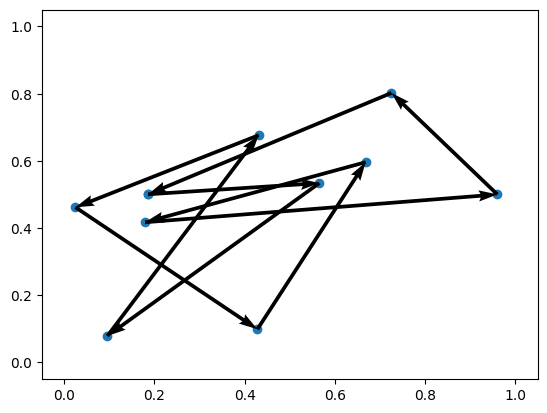

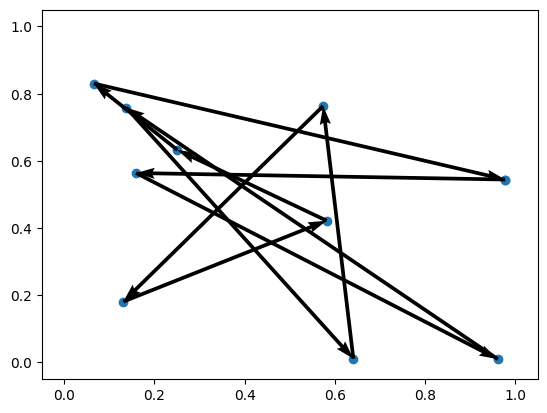

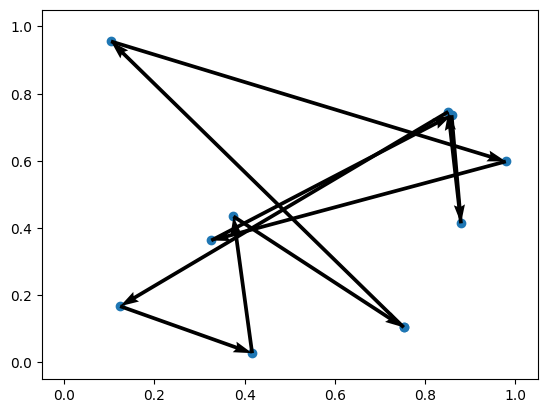

In [44]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [25]:
trainer = RL4COTrainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type                    | Params | Mode 
-----------------------------------------------------------
0 | env    | TSPEnv_StochasticTravel | 0      | train
1 | policy | AttentionModelPolicy    | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 196/196 [00:04<00:00, 48.39it/s, v_num=24, train/reward=-3.11, train/loss=-7.76, val/reward=-2.99]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:04<00:00, 48.28it/s, v_num=24, train/reward=-3.11, train/loss=-7.76, val/reward=-2.99]


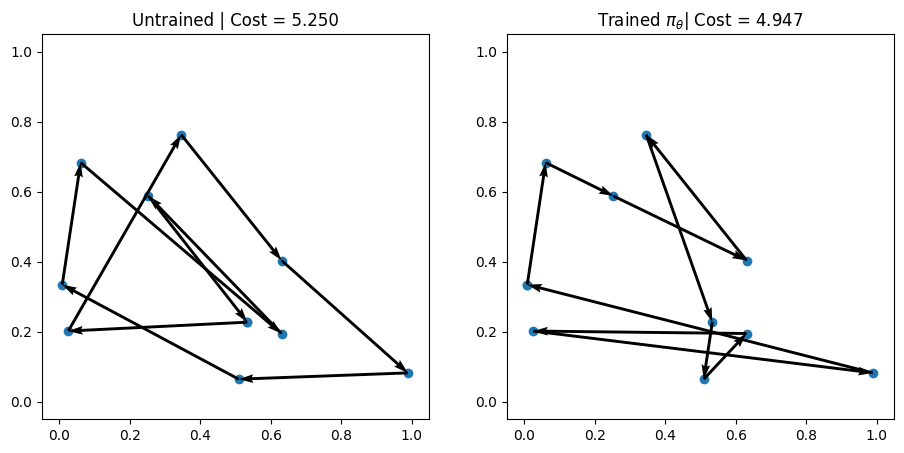

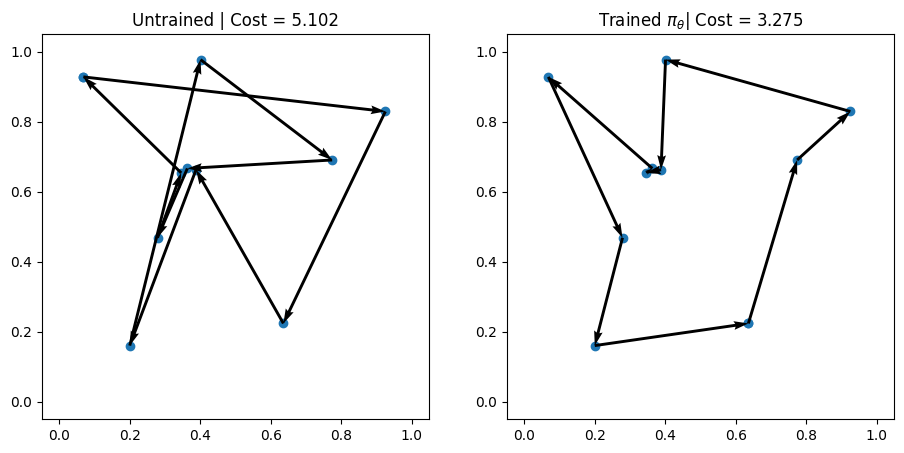

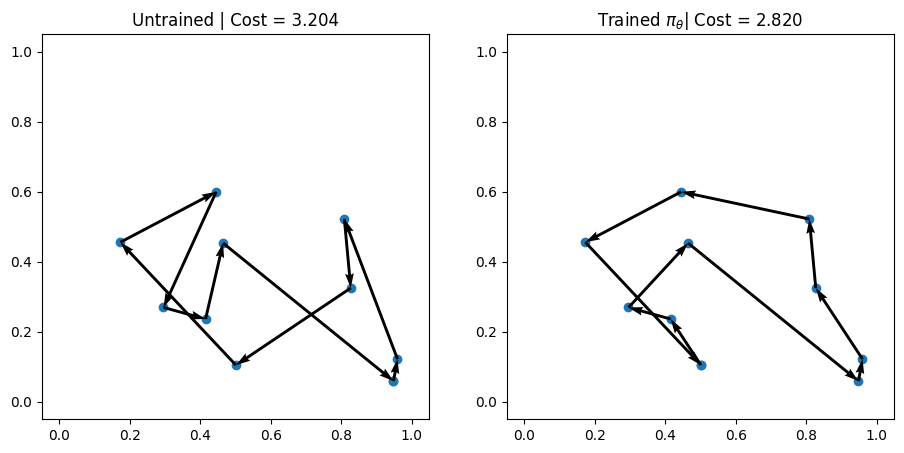

In [27]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

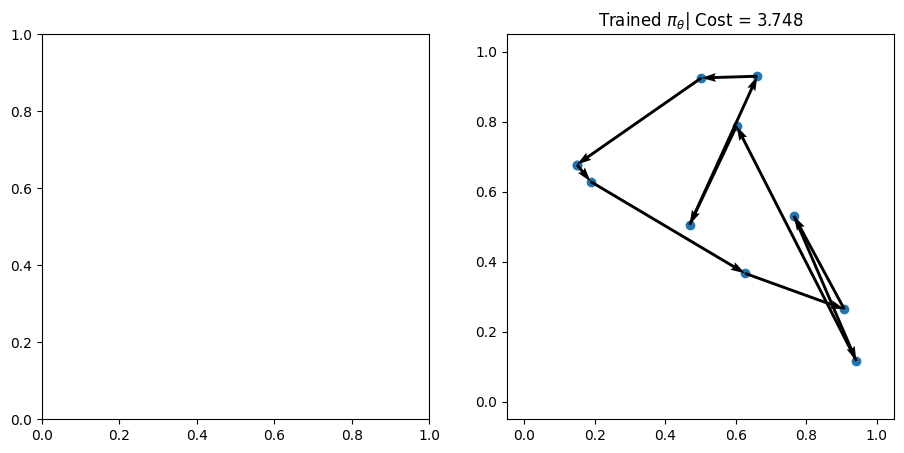

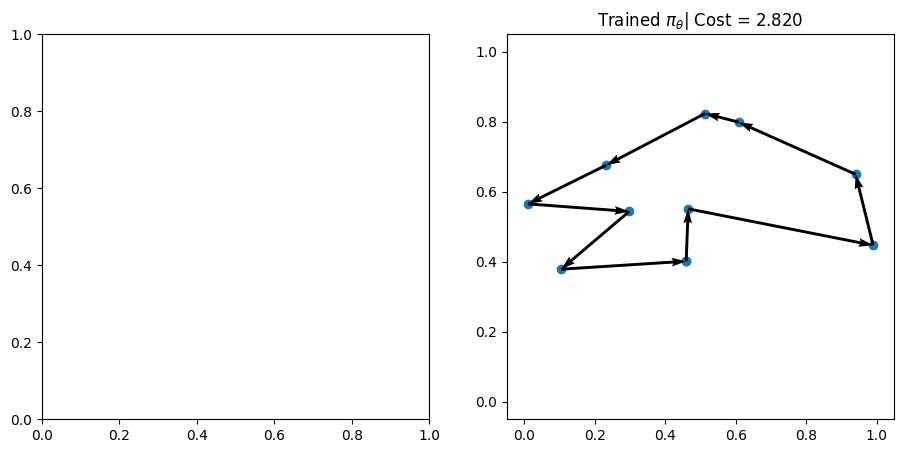

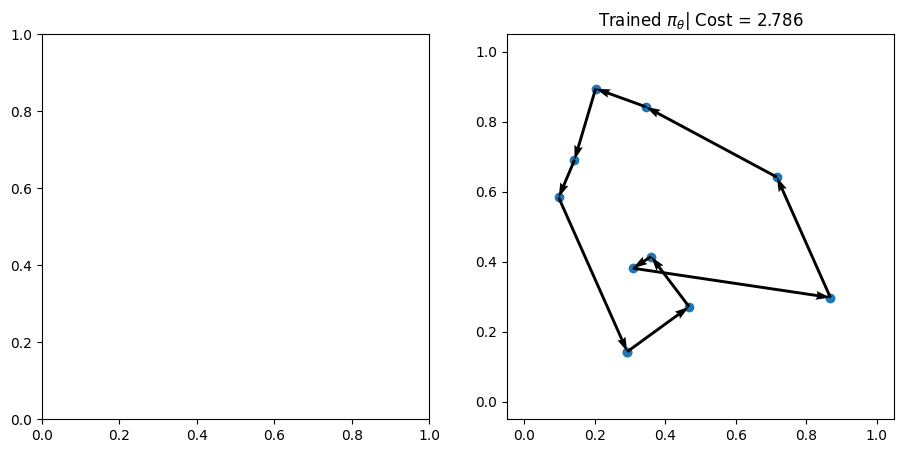

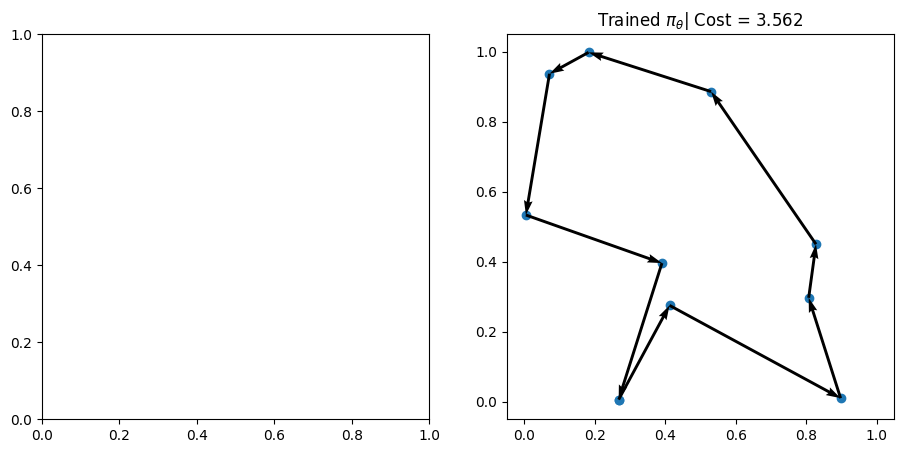

In [32]:
td_init = env.reset(batch_size=[4]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

In [37]:
td_init['first_node']

tensor([0, 0, 0, 0], device='cuda:0')